# Access and process satellite imagery using Python

Objectives:
- Search public repositories of satellite imagery using Python.
- Inspect the search result metadata.
- Download (a subset of) the assets available for a satellite scene.
- Open the satellite imagery as raster data and setup some raster calculations.
- Process satellite images in "chunk" to take advantage of parallelization.


In [1]:
# TODO: add packages to environment
# !pip install stackstac pystac-client graphviz

## Search for satellite imagery

### SpatioTemporal Asset Catalog (STAC)

In [2]:
from pystac_client import Client

# Earth-Search STAC endpoint for Open Data collections on AWS
# https://registry.opendata.aws/sentinel-2-l2a-cogs
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)

In [3]:
# collection: Sentinel-2, Level 2A, COGs
collection = "sentinel-s2-l2a-cogs"

In [4]:
# AMS coordinates
lat, lon = 52.37, 4.90  

In [5]:
coords = dict(type="Point", coordinates=(lon, lat))
mysearch = client.search(
    collections=[collection],
    intersects=coords,
    max_items=10,
)

In [6]:
print(mysearch.matched())

612


In [7]:
items = mysearch.get_all_items()
print(len(items))

10


In [8]:
for item in items:
    print(item)

<Item id=S2B_31UFU_20220122_0_L2A>
<Item id=S2A_31UFU_20220120_0_L2A>
<Item id=S2A_31UFU_20220117_0_L2A>
<Item id=S2B_31UFU_20220115_0_L2A>
<Item id=S2B_31UFU_20220112_0_L2A>
<Item id=S2A_31UFU_20220110_0_L2A>
<Item id=S2A_31UFU_20220107_0_L2A>
<Item id=S2B_31UFU_20220105_0_L2A>
<Item id=S2B_31UFU_20220102_0_L2A>
<Item id=S2A_31UFU_20211231_0_L2A>


In [9]:
item = items[0]
item.properties

{'datetime': '2022-01-22T10:46:20Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32631,
 'sentinel:utm_zone': 31,
 'sentinel:latitude_band': 'U',
 'sentinel:grid_square': 'FU',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2B_MSIL2A_20220122T104239_N0301_R008_T31UFU_20220122T121827',
 'sentinel:data_coverage': 66.51,
 'eo:cloud_cover': 99.83,
 'sentinel:valid_cloud_cover': True,
 'created': '2022-01-22T16:20:48.994Z',
 'updated': '2022-01-22T16:20:48.994Z'}

### Exercise: Search satellite scenes using filters on metadata
Search for all the available Sentinel-2 assets in the `sentinel-s2-l2a-cogs` collection that satisfy the following conditions: 
- include a provided bounding box (use ±0.05 deg in lat/lon from the point: 52.37N 4.90E);
- have been recorded in 2021;
- have a cloud coverage smaller than 5%.

How many scenes are available? Save the search results in  JSON format.

#### Solution

In [10]:
from shapely.geometry import Point
p = Point(lon, lat)
bbox = p.buffer(0.05).bounds

In [11]:
mysearch = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2021-01-01/2021-12-31",
    query=["eo:cloud_cover<5"]
)
print(mysearch.matched())

42


In [12]:
items = mysearch.get_all_items()
items.save_object("mysearch.json")

### Access the assets

In [13]:
# List all assets of the first scene
assets = items[0].assets  
print(assets.keys())

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [14]:
# Print minimal asset descriptions
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [15]:
# We have access to the asset URLs (e.g., to download them) ...
print(assets["thumbnail"])

<Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FT/2021/12/21/0/preview.jpg>


In [17]:
import rioxarray

# ... or we can open them directly (and stream content only when necessary)
blue_band_href = assets["B02"].href
blue_band = rioxarray.open_rasterio(blue_band_href)
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

## Raster chunking and parallelization with Dask

### Chunked rasters

In [18]:
# use Dask Arrays as underlying data structure by setting the "chunks" argument
blue_band = rioxarray.open_rasterio(blue_band_href, chunks=(1, 4000, 4000))
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-c1087d0c696d5f3c39536fed2fe2da80<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

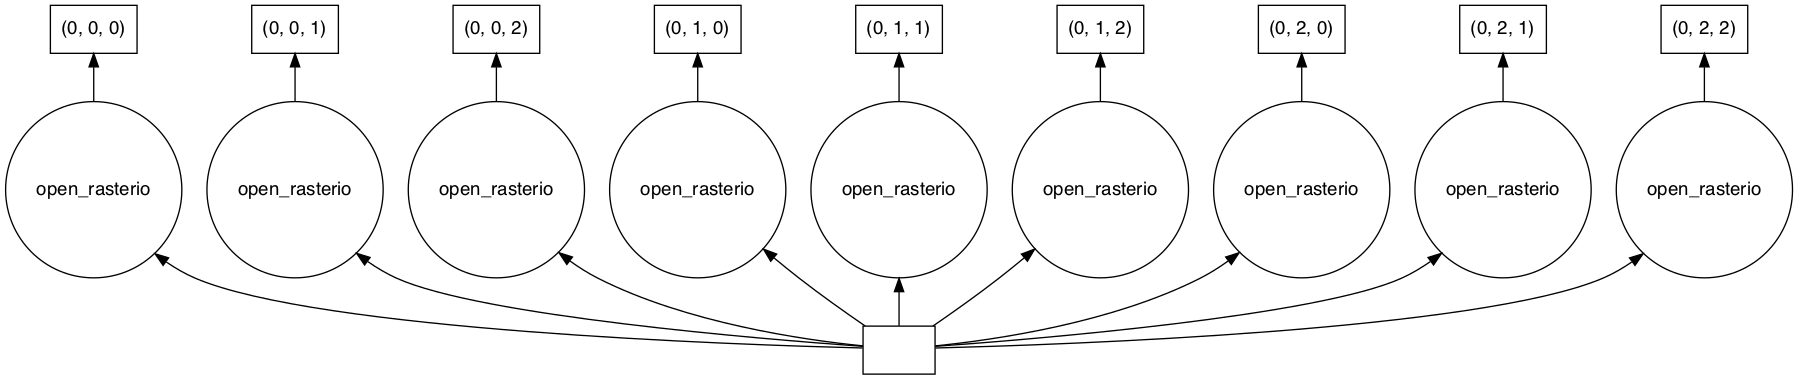

In [19]:
import dask
dask.visualize(blue_band)

### Exercise: Chunk size matters
Cloud optimized GeoTIFFs (COGs) are GeoTIFF files with a special internal structure. One feature of COGs is that data is organized in "blocks" that can be accessed via independent HTTP requests, enabling partial file readings (and, thus, efficient parallel access!). You can check the blocksize employed in a COG file with the following code snippet:
```python
import rasterio
with rasterio.open(cog_uri) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")
    else:
        print("File is not tiled!")
```
In order to optimally access COGs it is best to align the blocksize of the file with the chunks employed for the file read. Open the blue-band asset (`B02`) of a Sentinel-2 scene as a chunked `DataArray` object using suitable chunksize values. Which elements do you think should be considered when choosing these values? 

#### Solution

In [20]:
band_url = assets["B02"].href

In [21]:
import rasterio
with rasterio.open(band_url) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")
    else:
        print("File is not tiled!")

Chunk size: [(1024, 1024)]


In [22]:
# Use multiple of 1024, but try to avoid too small chunks
band = rioxarray.open_rasterio(band_url, chunks=(1, 6144, 6144))
band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-7178b99f5cd7c1575a830b0b6b95a024<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 6144, 6144), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [23]:
# rioxarray can also try to guess best value
band = rioxarray.open_rasterio(band_url, chunks="auto")
band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-d7a0c5112b4a69e860ca2d8e7618b4d5<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

### Raster calculations using `stackstac`

In [153]:
import stackstac

### Exercise: Plot water bodies
Let's go back to the initial search for Sentinel-2 scenes including Amsterdam, only including 2021 scenes). Open the search results as a `DataArray` using `stackstac`, then filter for the scenes with no clouds (cloud coverage equal to zero). Crop the assets using the bounding box used earlier, then select the only scene classification map (asset `SCL`). Finally, plot the water bodies (see [the Sentinel-2 scene classification algorithm documentation](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm), Figure 3), making one subplot per scene. 
